# Sensitivity of slopes

In [15]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.colors as mcolors


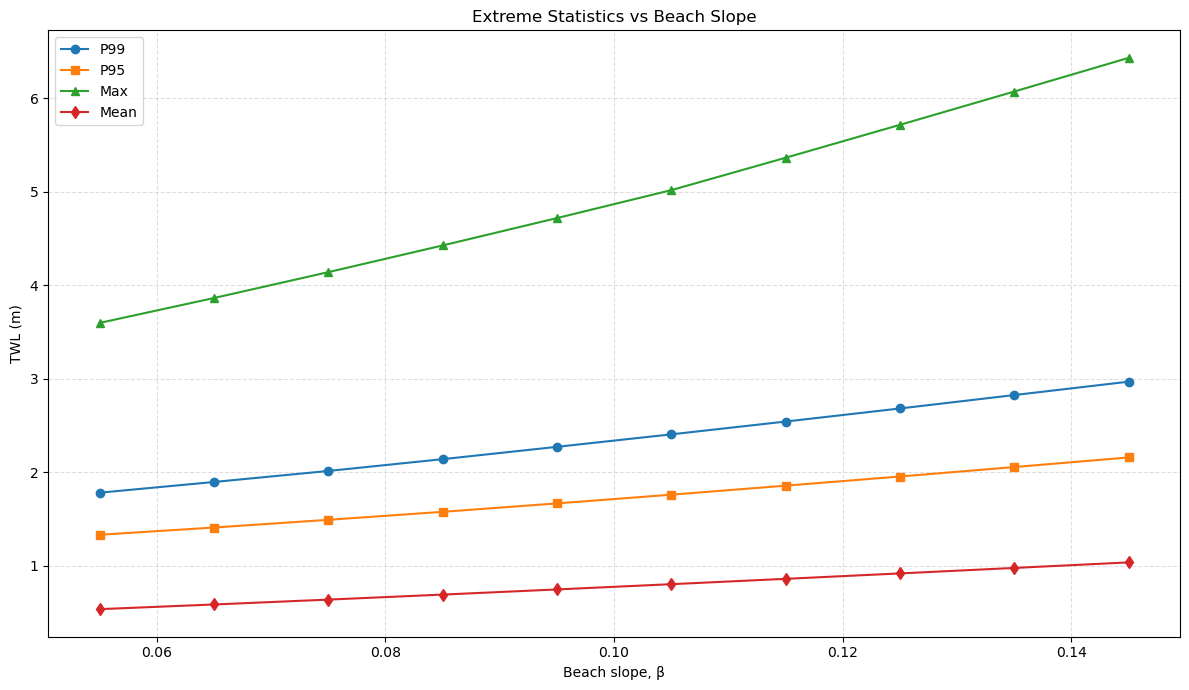

In [16]:


twl_csv = r'C:\Users\aadhau\OneDrive - University of Florida\1_UF_Coursework\Quant\Project\SRM\Shoreline_Response_Model\data\Duck_NS_TWL_slopes.csv'

def parse_slope_columns(df):
    pairs = []
    patt = re.compile(r"^TWL_slope_([0-9]*\.?[0-9]+)$")
    for c in df.columns:
        m = patt.match(c)
        if m:
            beta = float(m.group(1))
            pairs.append((beta, c))
    pairs.sort(key=lambda x: x[0])
    return pairs

def main():
    df = pd.read_csv(twl_csv, parse_dates=["time"])
    slope_cols = parse_slope_columns(df)

    stats_rows = []
    for b, c in slope_cols:
        series = df[c].to_numpy()
        stats_rows.append({
            "slope": b,
            "mean": np.nanmean(series),
            "median": np.nanmedian(series),
            "P95": np.nanpercentile(series, 95),
            "P99": np.nanpercentile(series, 99),
            "max": np.nanmax(series),
        })

    stats_df = pd.DataFrame(stats_rows).sort_values("slope")

    x = stats_df["slope"].to_numpy()
    plt.figure(figsize=(12, 7))
    plt.plot(x, stats_df["P99"], marker="o", label="P99")
    plt.plot(x, stats_df["P95"], marker="s", label="P95")
    plt.plot(x, stats_df["max"], marker="^", label="Max")
    plt.plot(x, stats_df["mean"], marker="d", label="Mean")
    plt.title("Extreme Statistics vs Beach Slope")
    plt.xlabel("Beach slope, β")
    plt.ylabel("TWL (m)")
    plt.grid(True, ls="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(work_dir / "Duck_NS_TWL_extremes_by_slope.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()


In [17]:

stats_csv = Path(
    r"C:\Users\aadhau\OneDrive - University of Florida\1_UF_Coursework\Quant\Project\Dataset\Decomposition\Slopes_tested\Duck_NS_TWL_extreme_stats.csv"
)

try:
    stats_df
except NameError:
    stats_df = pd.read_csv(stats_csv)

x = stats_df["slope"].to_numpy()
y_p99 = stats_df["P99"].to_numpy()
y_p95 = stats_df["P95"].to_numpy()
y_max = stats_df["max"].to_numpy()
y_mean = stats_df["mean"].to_numpy()

fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title("Extreme Statistics vs Beach Slope")
ax.set_xlabel("Beach slope, β")
ax.set_ylabel("TWL (m)")
ax.grid(True, ls="--", alpha=0.4)

x_pad = 0.01 * (x.max() - x.min() if x.max() > x.min() else 1.0)
ax.set_xlim(x.min() - x_pad, x.max() + x_pad)

y_all = np.concatenate([y_p99, y_p95, y_max, y_mean])
y_all = y_all[np.isfinite(y_all)]
y_min, y_maxv = np.min(y_all), np.max(y_all)
y_pad = 0.05 * (y_maxv - y_min if y_maxv > y_min else 1.0)
ax.set_ylim(y_min - y_pad, y_maxv + y_pad)

line_p99, = ax.plot([], [], marker="o", markersize=8, linewidth=2, label="P99")
line_p95, = ax.plot([], [], marker="s", markersize=8, linewidth=2, label="P95")
line_max, = ax.plot([], [], marker="^", markersize=8, linewidth=2, label="Max")
line_mean, = ax.plot([], [], marker="d", markersize=8, linewidth=2, label="Mean")
ax.legend(loc="upper left")

slope_text = ax.text(
    0.5, 0.95, "", transform=ax.transAxes,
    fontsize=18, ha="center", va="top",
    bbox=dict(facecolor="white", alpha=0.7)
)

lines = [line_p99, line_p95, line_max, line_mean]

def init():
    for ln in lines:
        ln.set_data([], [])
    slope_text.set_text("")
    return lines + [slope_text]

def update(frame):
    xi = x[:frame + 1]
    line_p99.set_data(xi, y_p99[:frame + 1])
    line_p95.set_data(xi, y_p95[:frame + 1])
    line_max.set_data(xi, y_max[:frame + 1])
    line_mean.set_data(xi, y_mean[:frame + 1])
    slope_text.set_text(f"β = {x[frame]:.3f}")
    return lines + [slope_text]

anim = FuncAnimation(
    fig,
    update,
    init_func=init,
    frames=len(x),
    interval=800,
    blit=True
)

gif_path = Path(
    r"C:\Users\aadhau\OneDrive - University of Florida\1_UF_Coursework\Quant\Project\SRM\Shoreline_Response_Model\Output\Sensitivity\extremes.gif"
)

anim.save(gif_path, writer=PillowWriter(fps=1))
plt.close(fig)

print(f"✅ Saved GIF at: {gif_path}")


✅ Saved GIF at: C:\Users\aadhau\OneDrive - University of Florida\1_UF_Coursework\Quant\Project\SRM\Shoreline_Response_Model\Output\Sensitivity\extremes.gif


In [18]:


g = 9.81
H0 = 2.0
T = 8.0
L0 = g * T**2 / (2 * np.pi)

def dR2_dBeta(beta, H0, L0):
    A = H0 * L0
    B = 0.563 * beta**2 + 0.004
    term1 = 0.35 * np.sqrt(A)
    term2 = 0.5 * np.sqrt(A) * (0.563 * beta) / np.sqrt(B)
    return 1.1 * (term1 + term2)

betas = np.linspace(0.00, 0.40, 120)
dR2_vals = dR2_dBeta(betas, H0, L0)

fig, ax = plt.subplots(figsize=(12, 7), dpi=120)

line_red, = ax.plot([], [], "r--", label="∂R₂%/∂βf")

ax.set_xlim(0.0, 0.50)
ax.set_ylim(6, 12)
ax.set_xlabel("Beach slope βf (-)")
ax.set_ylabel("∂R₂%/∂βf (m per unit slope)", color="r")
ax.tick_params(axis="y", labelcolor="r")
ax.grid(True, ls="--", alpha=0.4)
ax.legend(loc="upper left")

slope_text = ax.text(
    0.5, 0.92, "", transform=ax.transAxes,
    fontsize=18, ha="center", va="top",
    bbox=dict(facecolor="white", alpha=0.7)
)

def init():
    line_red.set_data([], [])
    slope_text.set_text("")
    return line_red, slope_text

def update(frame):
    line_red.set_data(betas[:frame + 1], dR2_vals[:frame + 1])
    slope_text.set_text(f"β = {betas[frame]:.3f}")
    return line_red, slope_text

anim = FuncAnimation(
    fig,
    update,
    init_func=init,
    frames=len(betas),
    interval=60,
    blit=False
)

gif_path = Path(
    r"C:\Users\aadhau\OneDrive - University of Florida\1_UF_Coursework\Quant\Project\SRM\Shoreline_Response_Model\Output\Sensitivity"
) / "sensitivity.gif"

anim.save(gif_path, writer=PillowWriter(fps=17))
plt.close(fig)

print(f"✅ Sensitivity GIF: {gif_path}")


✅ Sensitivity GIF: C:\Users\aadhau\OneDrive - University of Florida\1_UF_Coursework\Quant\Project\SRM\Shoreline_Response_Model\Output\Sensitivity\sensitivity.gif


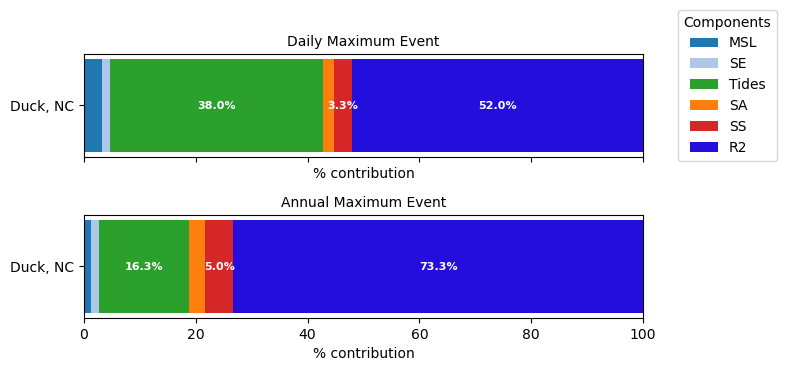

In [19]:


file_path = r"C:\Users\aadhau\OneDrive - University of Florida\1_UF_Coursework\Quant\Project\SRM\Shoreline_Response_Model\data\Duck_NS_decomposed.csv"

df = pd.read_csv(file_path)
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values("time")

components = ["MSL", "SE", "Tides", "SA", "SS", "R2"]
twl_col = "TWL"
site_name = "Duck, NC"

idx_daily_max = df.groupby(df["time"].dt.date)[twl_col].idxmax()
daily_max_df = df.loc[idx_daily_max].copy()
daily_max_df["date"] = daily_max_df["time"].dt.date

df["year"] = df["time"].dt.year
idx_annual_max = df.groupby("year")[twl_col].idxmax()
annual_max_df = df.loc[idx_annual_max].copy()
annual_max_df["year"] = annual_max_df["time"].dt.year

def compute_percent_contrib(df):
    for comp in components:
        df[f"%C_{comp}"] = (df[comp] / df[twl_col]) * 100
        df.loc[df[f"%C_{comp}"] < 0, f"%C_{comp}"] = 0
    percent_cols = [f"%C_{c}" for c in components]
    df[percent_cols] = df[percent_cols].div(df[percent_cols].sum(axis=1), axis=0) * 100
    mean_contrib = df[percent_cols].mean().rename(lambda x: x.replace("%C_", ""))
    return mean_contrib

mean_daily = compute_percent_contrib(daily_max_df)
mean_annual = compute_percent_contrib(annual_max_df)

colors = {
    "MSL": "#1f77b4",
    "SE": "#aec7e8",
    "Tides": "#2ca02c",
    "SA": "#ff7f0e",
    "SS": "#d62728",
    "R2": "#230edb",
}

def get_text_color(hex_color):
    r, g, b = mcolors.to_rgb(hex_color)
    brightness = (r * 299 + g * 587 + b * 114) / 1000
    return "black" if brightness > 0.6 else "white"

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4), sharex=True)
datasets = [(mean_daily, "Daily Maximum Event"), (mean_annual, "Annual Maximum Event")]
annotate_components = ["R2", "SS", "Tides"]

for ax, (data, title) in zip(axes, datasets):
    start = 0
    for comp in components:
        width = data[comp]
        color = colors[comp]
        ax.barh(site_name, width, left=start, color=color, label=comp)
        if comp in annotate_components and width > 0:
            text_color = get_text_color(color)
            ax.text(
                start + width / 2,
                0,
                f"{width:.1f}%",
                va="center",
                ha="center",
                fontsize=8,
                color=text_color,
                fontweight="bold",
            )
        start += width
    ax.set_xlim(0, 100)
    ax.set_title(title, fontsize=10)
    ax.set_ylabel("")
    ax.set_xlabel("% contribution")

axes[0].legend(title="Components", bbox_to_anchor=(1.05, 1.5), loc="upper left")

plt.tight_layout()
plt.show()
